In [64]:
import numpy as np
import networkx as nx
import osmnx as ox
import pandas as pd
import sklearn

So, we have our map of Manhattan below 34th St and a dummy danger metric. Let's start by loading those and displaying them.

In [2]:
crash_df = pd.read_csv('../../data/DUMMY_CRASH_AVG_FOR_CORRELATION_TESTS_node_id_census_tract_key.csv')
crash_df.head()

,Unnamed: 0,CRASH_AVG,NODE_ID,CENSUS_TRACT_ID
0,0,0.000000,42421828,2800
1,1,0.000000,42421837,2800
2,27,0.000272,42421877,6300
3,52,0.000032,42421889,7100
4,72,0.000000,42421927,5502


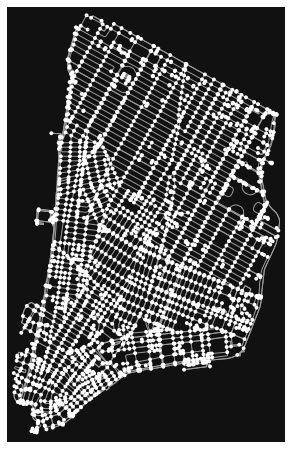

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [3]:
G = ox.io.load_graphml('../../data/mnh_below_34th.graphml')
ox.plot_graph(G)

Cool. Now that we have these two datasets, let's try displaying the average number of crashes for each node.

In [5]:
crash_avg_by_node = crash_df.set_index('NODE_ID')['CRASH_AVG']

def saturate_nodes(G, s):
    for node_id in G.nodes:
        if node_id in s.index:
            continue
        else:
            s.loc[node_id] = 0
    return s

crash_avg_by_node = saturate_nodes(G, crash_avg_by_node)

<AxesSubplot:>

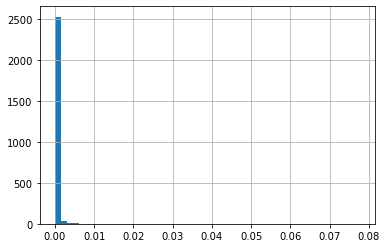

In [51]:
crash_avg_by_node.hist(bins=50)

It looks like the vast, vast majority of intersections had no crashes. Let's switch to a log scale, add a bias of 1, and scale up the non-zero crash averages by several orders of magnitude. This will keep all of the places that have zero crashes at 0 but make the bias not skew the relative results for anywhere else.

<AxesSubplot:>

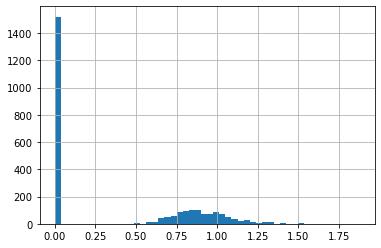

In [47]:
scaled_crash_avg_by_node = np.log(crash_avg_by_node * 1e6 + 1)
scaled_crash_avg_by_node.hist(bins=50)

Now we have a much more visible normal distribution for the nodes that had any crashes. For better interpretability of the results, let's now try filtering off all of the 0 crash-intersections.

<AxesSubplot:>

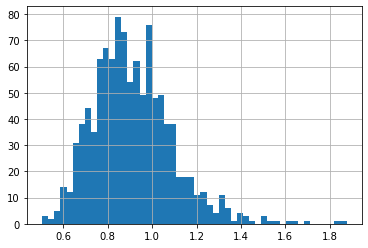

In [77]:
scaled_crash_avg_by_node[scaled_crash_avg_by_node > 0].hist(bins=50)

We scan see a clear normal distribution here with some outlier intersections with more crashes. This scaling process that we did here is a little bit non-standard. Let's use a standard sklearn scaler that does a similar transormation to what we did here but a little more robustly; `PowerTransformer`.

<AxesSubplot:>

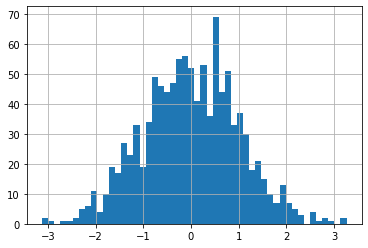

In [79]:
scaler = sklearn.preprocessing.PowerTransformer(method='box-cox')
scaled_crash_avg_by_node = pd.Series(scaler.fit_transform(np.asarray(crash_avg_by_node[crash_avg_by_node > 0]).reshape(-1, 1)).ravel())
scaled_crash_avg_by_node.hist(bins=50)

Sweet. This is a delightfully low-skew normal distribution. Let's try putting it on the map to see if anything stands out.

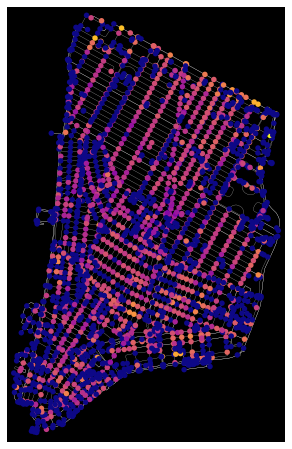

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [80]:
# Now we set the node attributes to be this crash count
nx.set_node_attributes(G, dict(scaled_crash_avg_by_node), "crash_avg")
# Now we map these to colors
nc = ox.plot.get_node_colors_by_attr(G, "crash_avg", cmap="plasma")
# Now we plot the graph with the colors
ox.plot_graph(
    G,
    node_color=nc,
    node_size=30,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
    bgcolor="k",
)